In [1]:
%matplotlib inline

import sys
import os
sys.path.append('C:/Users/samrari/ComputBuffer')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from skimage import exposure, img_as_float, morphology

from osgeo import gdal
import osr
import xml.etree.ElementTree as ET
import os, fnmatch

from my_packages.My_Geoprocess import*

In [2]:

GridOptions(options=[], format='GTiff', outputType=GDT_Unknown, width=0, height=0, creationOptions=None, outputBounds=None, outputSRS=None, noData=None, algorithm=None, layers=None, SQLStatement=None, where=None, spatFilter=None, zfield=None, z_increase=None, z_multiply=None, callback=None, callback_data=None)
source code 
Create a GridOptions() object that can be passed to gdal.Grid()
Keyword arguments are :
  options --- can be be an array of strings, a string or let empty and filled from other keywords.
  format --- output format ("GTiff", etc...)
  outputType --- output type (gdal.GDT_Byte, etc...)
  width --- width of the output raster in pixel
  height --- height of the output raster in pixel
  creationOptions --- list of creation options
  outputBounds --- assigned output bounds: [ulx, uly, lrx, lry]
  outputSRS --- assigned output SRS
  noData --- nodata value
  algorithm --- e.g "invdist:power=2.0:smoothing=0.0:radius1=0.0:radius2=0.0:angle=0.0:max_points=0:min_points=0:nodata=0.0"
  layers --- list of layers to convert
  SQLStatement --- SQL statement to apply to the source dataset
  where --- WHERE clause to apply to source layer(s)
  spatFilter --- spatial filter as (minX, minY, maxX, maxY) bounding box
  zfield --- Identifies an attribute field on the features to be used to get a Z value from. This value overrides Z value read from feature geometry record.
  z_increase --- Addition to the attribute field on the features to be used to get a Z value from. The addition should be the same unit as Z value. The result value will be Z value + Z increase value. The default value is 0.
  z_multiply - Multiplication ratio for Z field. This can be used for shift from e.g. foot to meters or from  elevation to deep. The result value will be (Z value + Z increase value) * Z multiply value.  The default value is 1.
  callback --- callback method
  callback_data --- user data for callback

SyntaxError: invalid syntax (<ipython-input-2-0ab888f6f963>, line 3)

In [ ]:
gridopt = gdal.GridOptions(format='GTiff', width= 10980,height= 10980, spatFilter=(165.9735606070099, -22.692427357900442,167.02786117314153, -21.691015824552036),  algorithm='invdist:power=2')
output = gdal.Grid('outputlinear.tif','newpoints.vrt',options=gridopt)

# Metadatas extraction, reading and checking

In [47]:
xml_filePath = "C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/"
xml_fileName = "MTD_MSIL1C.xml"
gdal.ErrorReset()
ds = gdal.Open( xml_filePath + xml_fileName )

if ds is None or gdal.GetLastErrorMsg() != '':
    print('xml failed to load')
    
DataSet_md = ds.GetMetadata()
SubDataSet_md = ds.GetMetadata('SUBDATASETS')
ds = []
DataSet_md


{'CLOUD_COVERAGE_ASSESSMENT': '0.7371',
 'DATATAKE_1_DATATAKE_SENSING_START': '2017-07-18T23:11:41.026Z',
 'DATATAKE_1_DATATAKE_TYPE': 'INS-NOBS',
 'DATATAKE_1_ID': 'GS2A_20170718T231141_010823_N02.05',
 'DATATAKE_1_SENSING_ORBIT_DIRECTION': 'DESCENDING',
 'DATATAKE_1_SENSING_ORBIT_NUMBER': '101',
 'DATATAKE_1_SPACECRAFT_NAME': 'Sentinel-2A',
 'DEGRADED_ANC_DATA_PERCENTAGE': '0',
 'DEGRADED_MSI_DATA_PERCENTAGE': '0',
 'FOOTPRINT': 'POLYGON((166.35532632901763 -21.6970894719947, 166.46954229960608 -21.722967647825207, 166.46958826624325 -21.7227815159352, 166.47163316358743 -21.7232445791535, 166.4716453848504 -21.723194893765147, 166.47183341263485 -21.72323722848605, 166.4718497080836 -21.72317095690131, 166.71071733633568 -21.7773031127493, 166.71050830013448 -21.778173871448455, 166.9264041597562 -21.83047594674156, 166.92645036494807 -21.830281694363315, 166.92658079158798 -21.830313185021467, 166.9266070084699 -21.830202736161407, 166.92874668649648 -21.830719126399448, 166.928830

In [48]:
# Try opening the 4 subdatasets
for i in range(4):
    gdal.ErrorReset()
    ds.append(gdal.Open(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)]))
    if ds is None or gdal.GetLastErrorMsg() != '':
        print('subdatasets failed to load')
        print(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)])
src_ds = ds[0]
ds[0].RasterCount

4

# Look for common footprints

In [49]:
# Define Raster Footprint

RasterWidth = src_ds.RasterXSize
RasterHeight = src_ds.RasterYSize
GT_ds = src_ds.GetGeoTransform()
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3] 

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (165.9735606070099, -22.692427357900442) 
Lower right corner :  (167.02786117314153, -21.691015824552036)


In [55]:
RasterWidth 600000.0000000000000000,7490200.0000000000000000 : 709800.0000000000000000,7600000.0000000000000000

10980

# Look for common footprints : checks xml files

In [50]:
RePath_xmlDirectory = 'Data_SHOM/Global'
TimeThres = 1950
#%timeit GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N))
#%timeit GetXml_byFootprint2(RePath_xmlDirectory, min_E, max_E, min_N, max_N)
Selected_xml, LoopCount, count = GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)

In [51]:
print('Number of xml files with common footprint: ',len(Selected_xml))
print('Number of xml within and without : ', count)
print('process check')
print(LoopCount)
print(np.sum(LoopCount))

Number of xml files with common footprint:  445
Number of xml within and without :  1287
process check
[417, 21, 6, 1]
445


# Look for common footprints : explore ascii

,Lat,Lon,Depth
0,-22.017672,166.115787,7.8
1,-22.010676,166.121261,5.6
2,-22.026873,166.124463,4.0
3,-22.009554,166.120820,6.3
4,-22.015910,166.110746,10.8
5,-22.023428,166.131901,2.1
6,-22.010717,166.127082,3.1
7,-22.011582,166.122602,5.3
8,-21.998838,166.117660,6.0
9,-22.003404,166.114625,7.5


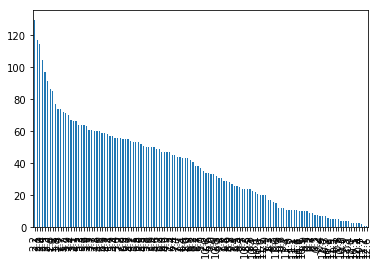

In [52]:
DepthPt = pd.read_csv(RePath_xmlDirectory+'/'+Selected_xml[0][:-10]+'ascii', delim_whitespace=True, header=None, names=['Lat','Lon','Depth'])
DepthPt_40m = DepthPt
DepthPt_counts = DepthPt_40m['Depth'].value_counts()
DepthPt_counts.plot(kind='bar')
len(DepthPt_40m)
DepthPt_40m

# Look for common footprints : filters ascii by depth and footprint

In [53]:
Upto = 1e6
Set , Count, failedXml = GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
assert np.sum(Count) == Set[1].shape[0]
Set[1].shape[0]

18640225

In [54]:
recordSurvey('Releves.csv', Set)

In [17]:
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)

px, py = GetPixel(ctInv, inv_geometrix, Set[1], integer=False)
px

no int


array([ 1421.35508749,  1152.88972983,  1380.58531821, ...,  6193.88884716,
        6211.20832806,  6196.62834129])

In [18]:
index = np.logical_or(np.logical_or(px>10979,px<0), np.logical_or(py>10979,py<0))
px, py = px[~index], py[~index]
depth=Set[2][~index]

In [45]:
from scipy import interpolate
ind = np.argsort(px)
ind[:-1][(px[ind][1:] - px[ind][:-1])==0] = False
f = interpolate.interp2d(px[ind],py[ind], depth[ind], copy=False)

OverflowError: Too many data points to interpolate

In [43]:
np.sum((px[ind][1:] - px[ind][:-1]) == 0)

0

In [38]:
a = np.arange(9)
a[:-1]

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
AverageDepth = np.zeros((RasterHeight, RasterWidth))
SurveyIndex = np.full((RasterHeight, RasterWidth), False, np.bool_)
for i in range(len(px)):
    try:
        int_py, int_px = int(py[i]),int(px[i])
        if H[int_px, int_py] == 0:
            continue
        SurveyIndex[int_px, int_py] = True
        AverageDepth[int_px, int_py] = AverageDepth[int_px, int_py] + (depth[i]/H[int_px, int_py])
    except:
        print(i)


In [ ]:
write_raster2('DensityMap.tiff', H, src_ds.GetGeoTransform(), src_ds.GetProjection(), DriverName="GTiff", formatMem=gdal.GDT_UInt16)
write_raster2('AverageBathy.tiff', AverageDepth, src_ds.GetGeoTransform(), src_ds.GetProjection(), DriverName="GTiff", formatMem=gdal.GDT_Float32)

In [ ]:
STD_Map = np.full((RasterHeight, RasterWidth), -1, np.float16)
for x in range(RasterHeight):
    for y in range(RasterWidth):
        if SurveyIndex[x,y]:
            ind = np.logical_and(np.logical_and(px>x,px<x+1), np.logical_and(py>y,py<y+1))
            STD_Map[x,y] = np.std(depth[ind]) 

In [ ]:
write_raster2('STD_Map.tiff', STD_Map, src_ds.GetGeoTransform(), src_ds.GetProjection(), DriverName="GTiff", formatMem=gdal.GDT_Float32)